# Module Import

In [1]:
import pandas as pd
import numpy as np
import openpyxl

# import statsmodels.formula.api as smf

from fbprophet import Prophet

import matplotlib.pyplot as plt
import seaborn as sns

import warnings

# pandas 경고 무시
pd.set_option('mode.chained_assignment',  None)

from matplotlib import font_manager, rc

font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

# Data Load

In [2]:
data = pd.read_csv('../data/행정자치부 공공데이터 숙박업 등록현황.csv', encoding = 'cp949')
# 데이터 출처 : 공공데이터포털 / 행정안전부_숙박업 데이터
# https://www.data.go.kr/data/15044968/fileData.do
print(data.shape)
data.head()

(54051, 51)


,번호,개방서비스명,개방서비스아이디,개방자치단체코드,관리번호,인허가일자,인허가취소일자,영업상태구분코드,영업상태명,상세영업상태코드,...,조건부허가시작일자,조건부허가종료일자,건물소유구분명,세탁기수,여성종사자수,남성종사자수,회수건조수,침대수,다중이용업소여부,Unnamed: 50
0,1,숙박업,03_11_03_P,3620000,3620000-201-2005-00005,20050818,NaN,1,영업/정상,1,...,NaN,NaN,임대,0.0,NaN,NaN,0.0,0.0,N,NaN
1,2,숙박업,03_11_03_P,3620000,3620000-201-2000-00013,20000615,NaN,1,영업/정상,1,...,NaN,NaN,NaN,0.0,NaN,NaN,0.0,0.0,N,NaN
2,3,숙박업,03_11_03_P,3620000,3620000-214-1985-00002,19851119,NaN,1,영업/정상,1,...,NaN,NaN,자가,0.0,NaN,NaN,0.0,0.0,N,NaN
3,4,숙박업,03_11_03_P,3620000,3620000-201-2000-00014,20000710,NaN,1,영업/정상,1,...,NaN,NaN,자가,0.0,NaN,NaN,0.0,0.0,N,NaN
4,5,숙박업,03_11_03_P,3620000,3620000-201-2002-00007,20020429,NaN,1,영업/정상,1,...,NaN,NaN,NaN,0.0,NaN,NaN,0.0,0.0,N,NaN


# Data Preprocessing

In [3]:
# 영업중인 숙박시설만 추출
df = data[data['상세영업상태명']=="영업"]

# 필요한 열만 추출 
df = df[['사업장명','업태구분명', '인허가일자']]

# 인허가일자 중 연도만 추출
df['인허가일자'] = df['인허가일자'].apply(lambda x: str(x)[:4])
df['인허가일자'] = df['인허가일자'].astype(int)

# 2022년 데이터 제거
df = df[df['인허가일자']<2022]

df = df.rename(columns={'사업장명':'name', '업태구분명':'type', '인허가일자':'year'})

In [4]:
# 숙박업 유형별 가격 산정 / 예상숙박업소가격*예상평균숙박업소객실수*30일*12개월

def price(x):
    if x == '여관업':
        return 30000*20*30*12
    elif x == '숙박업(생활)':
        return 60000*30*50*12
    elif x == '일반호텔':
        return 80000*50*30*12
    elif x == '여인숙업':
        return 30000*20*30*12
    elif x == '숙박업 기타':
        return 30000*20*30*12
    elif x == '관광호텔':
        return 80000*50*30*12
    else:
        return 150000*100*30*12
    
# 숙박업 유형 변경
def hoteltype(x):
    if x == '숙박업(생활)':
        return '생활형숙박시설'
    else:
        return '일반숙박시설'

In [5]:
df['price'] = df['type'].apply(price)
df['type'] = df['type'].apply(hoteltype)
df.head()

,name,type,year,price
0,야자,일반숙박시설,2005,216000000
1,엔(N)모텔,일반숙박시설,2000,216000000
2,디오앤에스임동,생활형숙박시설,1985,1080000000
3,에로스모텔,일반숙박시설,2000,216000000
4,클라우드인호텔,일반숙박시설,2002,216000000


In [6]:
# 2010년 이후 데이터만 출력

after2010 = df[df['year']>=2010]
df_normal = after2010[after2010['type']=='일반숙박시설']
df_residence = after2010[after2010['type']=='생활형숙박시설']
display(df_normal.head())
display(df_residence.head())

,name,type,year,price
6,게스트 145,일반숙박시설,2017,1440000000
33,파라다이스모텔,일반숙박시설,2011,216000000
40,네모모텔,일반숙박시설,2018,216000000
43,프리마,일반숙박시설,2016,216000000
58,아리랑 민속모텔,일반숙박시설,2010,216000000


,name,type,year,price
330,청춘게스트하우스 호스텔,생활형숙박시설,2017,1080000000
349,부례관광지바이크텔,생활형숙박시설,2017,1080000000
354,대가야왕가마을,생활형숙박시설,2010,1080000000
412,호텔로제니아,생활형숙박시설,2014,1080000000
479,별빛테마마을 펜션동,생활형숙박시설,2018,1080000000


# Time-Series

### fbprophet

- normal

In [7]:
data_normal = df[df['type']=='일반숙박시설']

normal = data_normal.groupby('year')[['price']].sum().reset_index()
normal.rename(columns={'type':'price'}, inplace=True)
normal['type'] = '일반숙박시설'
normal['cumsum'] = normal['price'].cumsum()
normal = normal[['year', 'type', 'price', 'cumsum']]

normal_ts = pd.DataFrame({'ds':normal['year'], 'y':normal['price']})
normal_ts['ds'] = normal_ts['ds'].astype(str)
normal_ts['ds'] = pd.to_datetime(normal_ts['ds'])
normal_ts.tail()

,ds,y
62,2017-01-01,425592000000
63,2018-01-01,343800000000
64,2019-01-01,330840000000
65,2020-01-01,259056000000
66,2021-01-01,270864000000


In [8]:
prophet = Prophet(seasonality_mode = 'multiplicative',
                 yearly_seasonality=True, 
                 weekly_seasonality=False,
                 daily_seasonality=False,
                 changepoint_prior_scale=0.5)

prophet.fit(normal_ts)


C:\Users\zyunhyeok\anaconda3\envs\prophet\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


In [9]:
future_data = prophet.make_future_dataframe(periods = 5, freq = 'y')
forecast_data = prophet.predict(future_data)
forecast_data[['ds','yhat', 'yhat_lower', 'yhat_upper']].tail(5)

C:\Users\zyunhyeok\anaconda3\envs\prophet\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\zyunhyeok\anaconda3\envs\prophet\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


,ds,yhat,yhat_lower,yhat_upper
67,2021-12-31,3.766711e+11,3.095108e+11,4.433892e+11
68,2022-12-31,3.892521e+11,3.111324e+11,4.669004e+11
69,2023-12-31,4.015037e+11,3.040461e+11,5.117976e+11
70,2024-12-31,4.169492e+11,2.649996e+11,5.953928e+11
71,2025-12-31,4.297764e+11,1.803739e+11,6.989263e+11


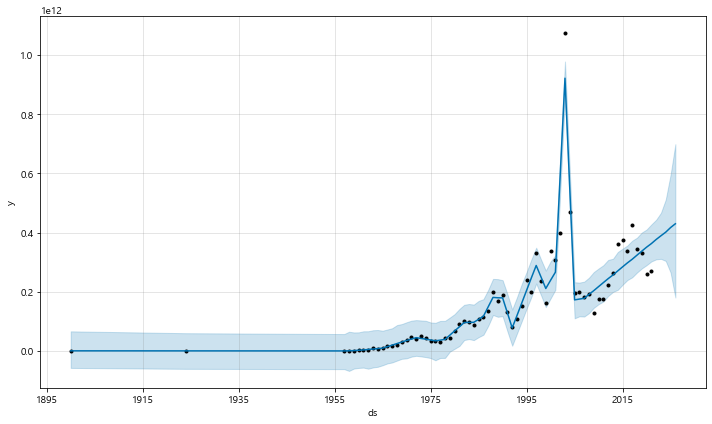

In [10]:
fig1 = prophet.plot(forecast_data)

C:\Users\zyunhyeok\anaconda3\envs\prophet\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\zyunhyeok\anaconda3\envs\prophet\lib\site-packages\fbprophet\plot.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)


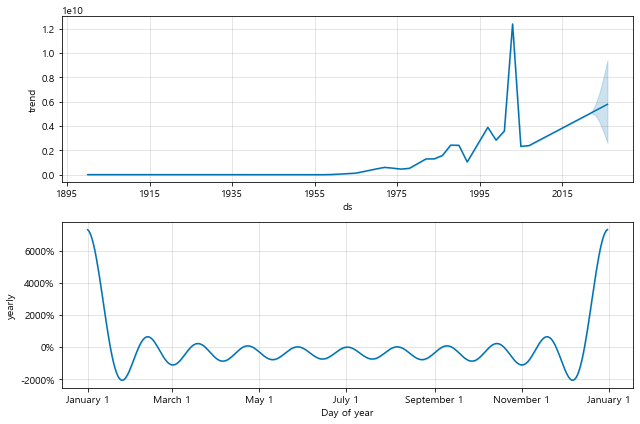

In [11]:
fig2 = prophet.plot_components(forecast_data)

In [12]:
x = np.arange(2010,2026)
y_normal = list(df_normal.groupby('year')['price'].sum()[:11])
y_normal.extend(list(round(forecast_data['yhat'][-5:])))

lst_normal = pd.DataFrame({'year':x, 'price':y_normal})
lst_normal['cumsum'] = lst_normal['price'].cumsum()
lst_normal['type'] = '일반숙박시설'
lst_normal = lst_normal[['year','type','price','cumsum']]
lst_normal

,year,type,price,cumsum
0,2010,일반숙박시설,1.756080e+11,1.756080e+11
1,2011,일반숙박시설,1.767600e+11,3.523680e+11
2,2012,일반숙박시설,2.236320e+11,5.760000e+11
3,2013,일반숙박시설,2.648160e+11,8.408160e+11
4,2014,일반숙박시설,3.620880e+11,1.202904e+12
5,2015,일반숙박시설,3.761280e+11,1.579032e+12
6,2016,일반숙박시설,3.366720e+11,1.915704e+12
7,2017,일반숙박시설,4.255920e+11,2.341296e+12
8,2018,일반숙박시설,3.438000e+11,2.685096e+12
9,2019,일반숙박시설,3.308400e+11,3.015936e+12


- residence

In [13]:
data_residence = df[df['type']=='생활형숙박시설']

residence = data_residence.groupby('year')[['price']].sum().reset_index()
residence.rename(columns={'type':'price'}, inplace=True)
residence['type'] = '생활형숙박시설'
residence['cumsum'] = residence['price'].cumsum()
residence = normal[['year', 'type', 'price', 'cumsum']]

residence_ts = pd.DataFrame({'ds':residence['year'], 'y':residence['price']})
residence_ts['ds'] = residence_ts['ds'].astype(str)
residence_ts['ds'] = pd.to_datetime(residence_ts['ds'])
residence_ts.tail()

,ds,y
62,2017-01-01,425592000000
63,2018-01-01,343800000000
64,2019-01-01,330840000000
65,2020-01-01,259056000000
66,2021-01-01,270864000000


In [14]:
prophet = Prophet(seasonality_mode = 'multiplicative',
                 yearly_seasonality=True, 
                 weekly_seasonality=True,
                 daily_seasonality=True,
                 changepoint_prior_scale=0.5)

prophet.fit(residence_ts)

C:\Users\zyunhyeok\anaconda3\envs\prophet\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


In [15]:
future_data = prophet.make_future_dataframe(periods = 5, freq = 'y')
forecast_data = prophet.predict(future_data)
forecast_data[['ds','yhat', 'yhat_lower', 'yhat_upper']].tail(5)

C:\Users\zyunhyeok\anaconda3\envs\prophet\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\zyunhyeok\anaconda3\envs\prophet\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


,ds,yhat,yhat_lower,yhat_upper
67,2021-12-31,3.275161e+11,2.765443e+11,3.766888e+11
68,2022-12-31,3.953358e+11,3.245562e+11,4.582757e+11
69,2023-12-31,4.483359e+11,3.253272e+11,5.580830e+11
70,2024-12-31,3.342696e+11,1.885034e+11,4.754550e+11
71,2025-12-31,4.954721e+11,1.774875e+11,7.719871e+11


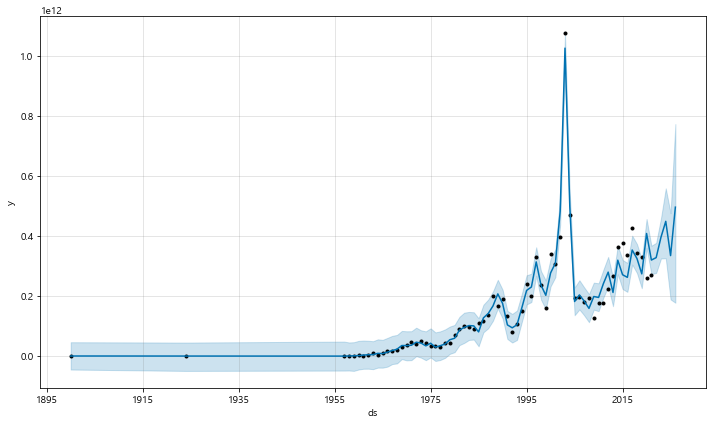

In [16]:
fig1 = prophet.plot(forecast_data)

C:\Users\zyunhyeok\anaconda3\envs\prophet\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\zyunhyeok\anaconda3\envs\prophet\lib\site-packages\fbprophet\plot.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)
C:\Users\zyunhyeok\anaconda3\envs\prophet\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\zyunhyeok\anaconda3\envs\prophet\lib\site-packages\fbprophet\plot.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)
C:\Users\zyunhyeok\anaconda3\envs\prophet\lib\site-packages\fbprophet\forecaster.py:89

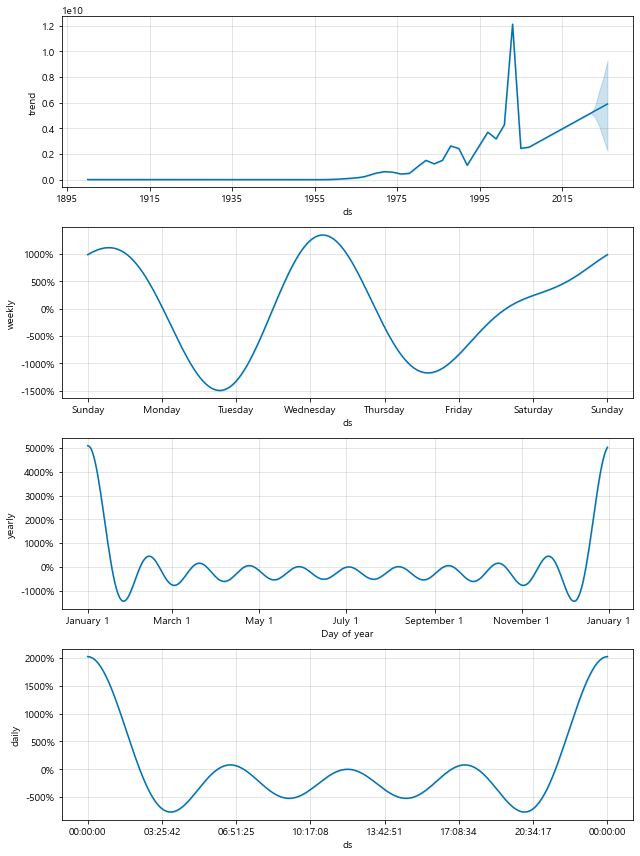

In [17]:
fig2 = prophet.plot_components(forecast_data)

In [22]:
x = np.arange(2010,2026)
y_residence = list(df_residence.groupby('year')['price'].sum()[:11])
y_residence.extend(list(round(forecast_data['yhat'][-5:])))

lst_residence = pd.DataFrame({'year':x, 'price':y_residence})
lst_residence['cumsum'] = lst_residence['price'].cumsum()
lst_residence['type'] = '생활형숙박시설'
lst_residence = lst_residence[['year','type','price','cumsum']]
lst_residence

,year,type,price,cumsum
0,2010,생활형숙박시설,9.504000e+10,9.504000e+10
1,2011,생활형숙박시설,7.020000e+10,1.652400e+11
2,2012,생활형숙박시설,2.613600e+11,4.266000e+11
3,2013,생활형숙박시설,1.944000e+11,6.210000e+11
4,2014,생활형숙박시설,2.462400e+11,8.672400e+11
5,2015,생활형숙박시설,2.818800e+11,1.149120e+12
6,2016,생활형숙박시설,3.780000e+11,1.527120e+12
7,2017,생활형숙박시설,4.028400e+11,1.929960e+12
8,2018,생활형숙박시설,5.108400e+11,2.440800e+12
9,2019,생활형숙박시설,4.525200e+11,2.893320e+12


In [23]:
price_all = pd.concat([lst_normal, lst_residence])
price_all

,year,type,price,cumsum
0,2010,일반숙박시설,1.756080e+11,1.756080e+11
1,2011,일반숙박시설,1.767600e+11,3.523680e+11
2,2012,일반숙박시설,2.236320e+11,5.760000e+11
3,2013,일반숙박시설,2.648160e+11,8.408160e+11
4,2014,일반숙박시설,3.620880e+11,1.202904e+12
5,2015,일반숙박시설,3.761280e+11,1.579032e+12
6,2016,일반숙박시설,3.366720e+11,1.915704e+12
7,2017,일반숙박시설,4.255920e+11,2.341296e+12
8,2018,일반숙박시설,3.438000e+11,2.685096e+12
9,2019,일반숙박시설,3.308400e+11,3.015936e+12


# Data Visualization

In [20]:
parameters = {'axes.labelsize': 25,
          'axes.titlesize': 35,
          'xtick.labelsize': 15,
          'ytick.labelsize': 15}
plt.rcParams.update(parameters)

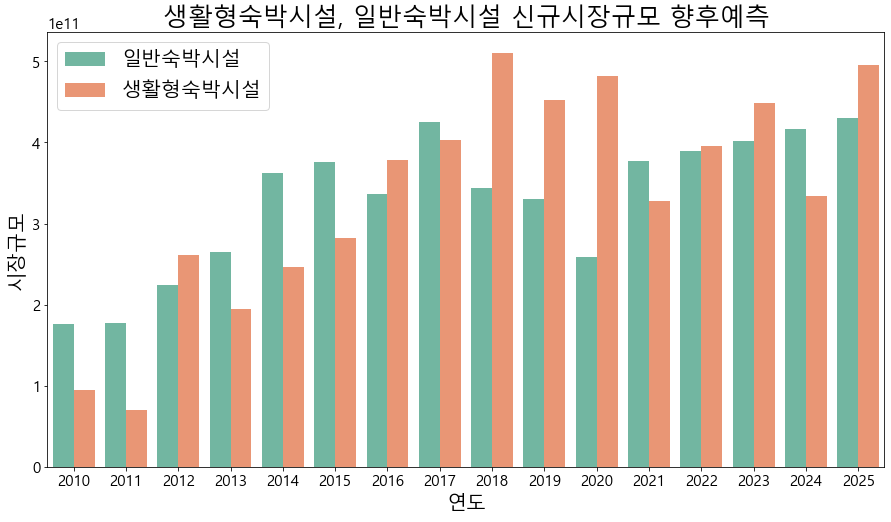

In [25]:
plt.figure(figsize=(15,8))
sns.barplot(data=price_all, x="year", y="price", hue="type", palette='Set2')

plt.title('생활형숙박시설, 일반숙박시설 신규시장규모 향후예측', fontsize=25)
plt.xlabel('연도', fontsize=20)
plt.ylabel('시장규모', fontsize=20)
plt.legend(fontsize=20, loc = 'best')
plt.show()

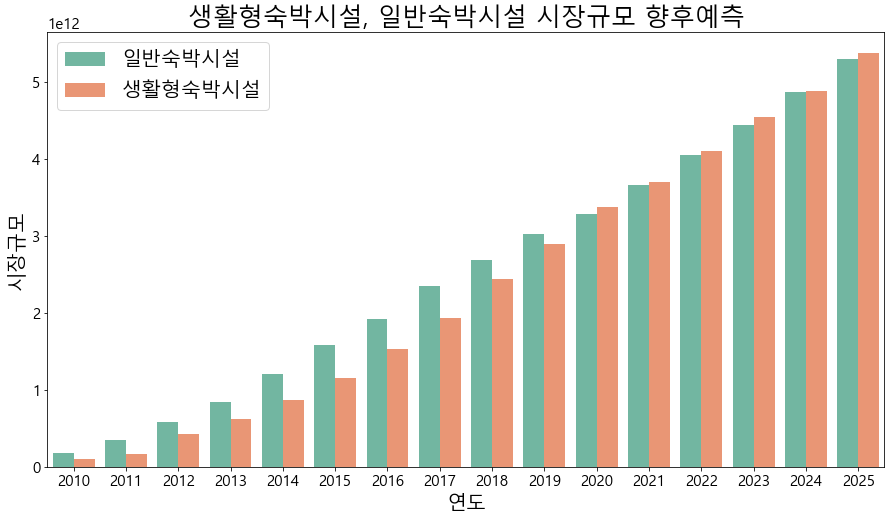

In [26]:
plt.figure(figsize=(15,8))
sns.barplot(data=price_all, x="year", y="cumsum", hue="type", palette='Set2')

plt.title('생활형숙박시설, 일반숙박시설 시장규모 향후예측', fontsize=25)
plt.xlabel('연도', fontsize=20)
plt.ylabel('시장규모', fontsize=20)
plt.legend(fontsize=20, loc = 'best')
plt.show()